In [2]:
import sys
import os
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import IPython.display as display


# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
import imp
#imp.reload(visualize)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from fashion_cnn import coco_main

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "model")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco_0_87_1_0069.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    print('here')
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
#SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

Using TensorFlow backend.


root_dir: C:\tensor_code
model_dir: C:\tensor_code\model
log_dir: C:\tensor_code\logs


In [61]:
import cv2

In [3]:
dataset = coco_main.FashionDataset()
json_file_dir = "C:/tensor_code/fashion/dataset/deepfashion2/train/coco_train_2.json"  # TODO: enter value here
image_dir="C:/tensor_code/fashion/dataset/deepfashion2/train/2"
dataset.load_coco(json_file_dir=json_file_dir,image_dir=image_dir)

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=22.80s)
creating index...
index created!
Image Count: 19196
Class Count: 14
  0. BG                                                
  1. short_sleeved_shirt                               
  2. long_sleeved_shirt                                
  3. short_sleeved_outwear                             
  4. long_sleeved_outwear                              
  5. vest                                              
  6. sling                                             
  7. shorts                                            
  8. trousers                                          
  9. skirt                                             
 10. short_sleeved_dress                               
 11. long_sleeved_dress                                
 12. vest_dress                                        
 13. sling_dress                                       


In [4]:
config = coco_main.FashionConfig()

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                26
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [5]:
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

W0205 18:20:11.841942 23208 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0205 18:20:11.867874 23208 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0205 18:20:11.885827 23208 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0205 18:20:11.958631 23208 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0205 18:20:11.968605 23208 deprecation_wrapper.py:119]

In [8]:
print("Loading weights ", COCO_MODEL_PATH)
model.load_weights(COCO_MODEL_PATH, by_name=True)

Loading weights  C:\tensor_code\fashion\model\mask_rcnn_coco_0_87_1_0069.h5


image ID: coco.42858 (4465) http://cocodataset.org/#explore?id=42858
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (2,)                  min:    4.00000  max:    8.00000  int32
gt_bbox                  shape: (2, 4)                min:  297.00000  max:  905.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool


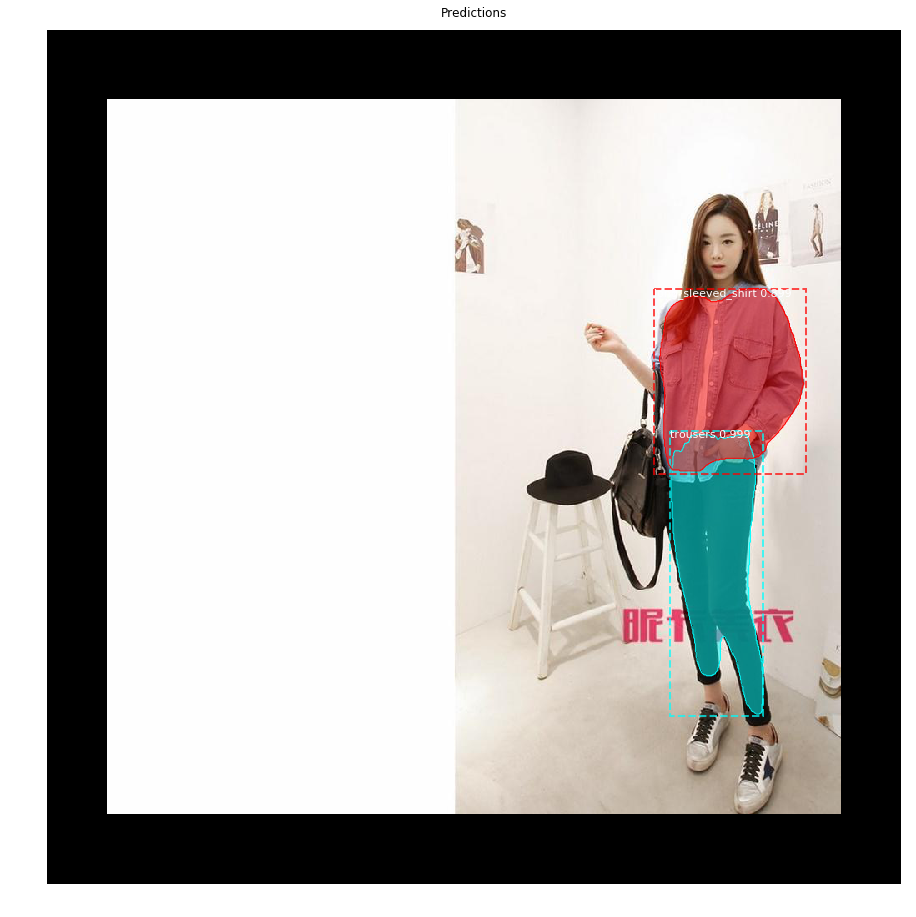

In [39]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

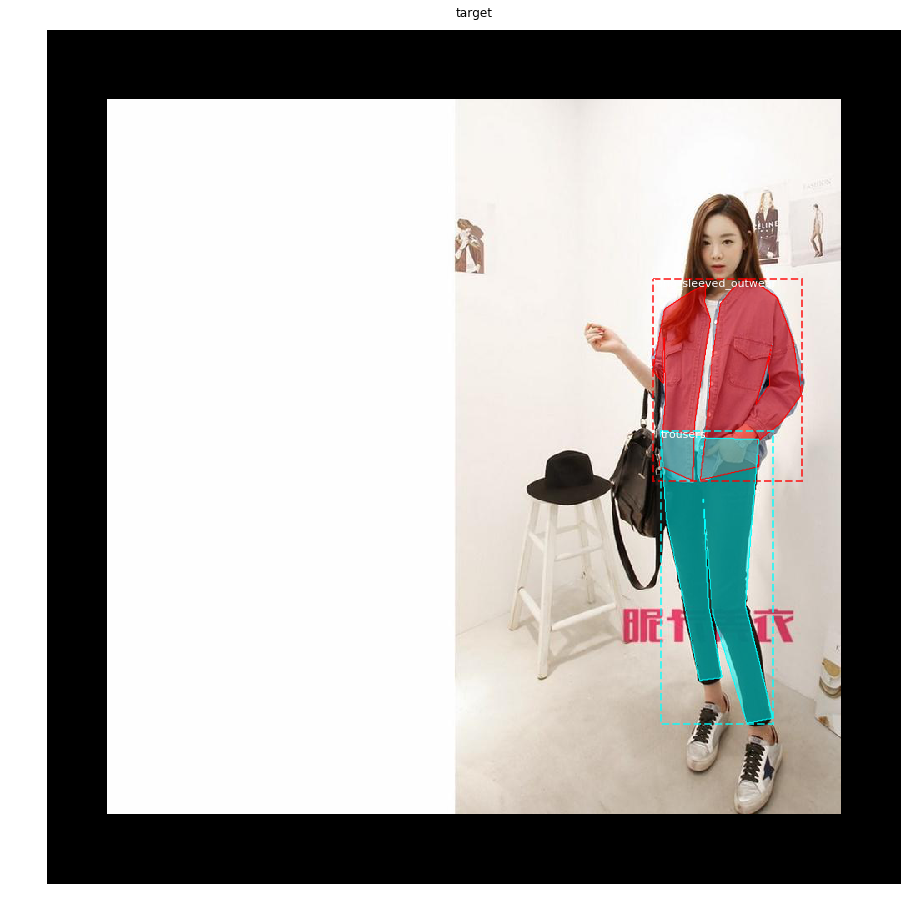

In [41]:
ax = get_ax(1)
visualize.display_instances(image, gt_bbox, gt_mask,gt_class_id,dataset.class_names,  ax=ax,title="target")

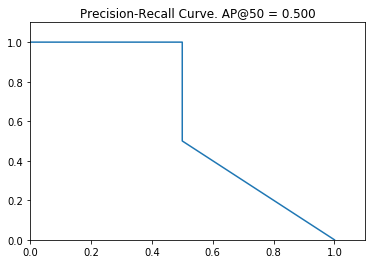

In [42]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

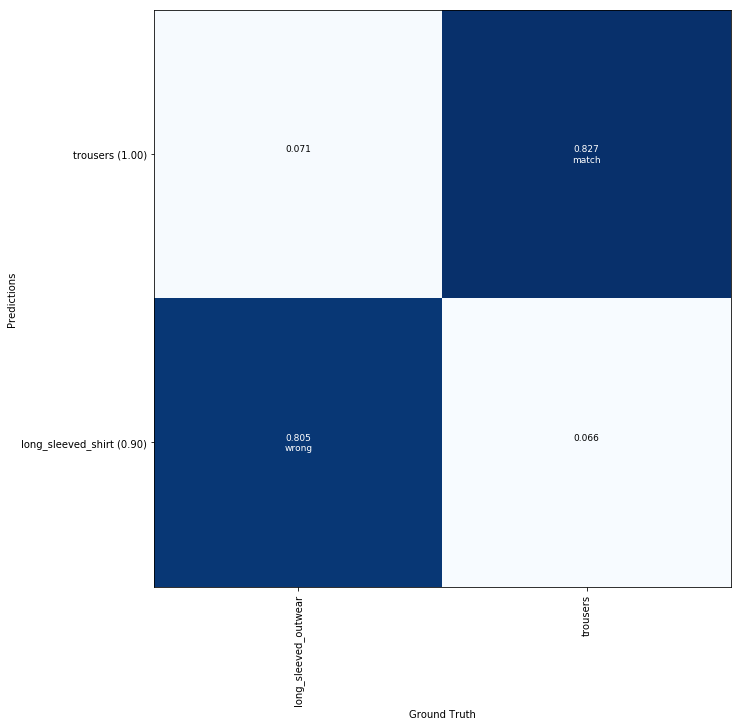

In [43]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

## Check dolor distribution

In [44]:
import skimage

In [45]:
def get_colort_values(image,mask):
    '''return r,g,b values of given clothes'''

    assert len(mask.shape)==2
    assert image.shape[-1]==3
    
    r_values=image[:,:,0][mask]
    g_values=image[:,:,1][mask]
    b_values=image[:,:,2][mask]
    
    return r_values,g_values,b_values

color distribution of long_sleeved_shirt


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


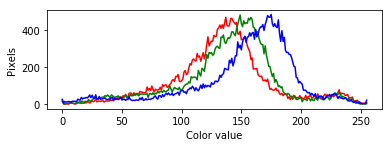

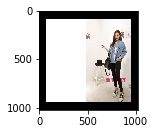

In [74]:
colors = ("r", "g", "b")
channel_ids = (0, 1, 2)

#n번 category mask 추출
prediction_id=1
mask=results[0]['masks'][:,:,prediction_id]
category_id=results[0]['class_ids'][prediction_id]
category_name=dataset.class_names[category_id]
#mask에 해당하는 영역의 r,g,b 값 추출
color_values=get_colort_values(image,mask)

# create the histogram plot, with three lines, one for
# each color
print('color distribution of %s'%category_name)
plt.xlim([0, 256])
for idx,color in enumerate(zip(channel_ids, colors)):
    histogram, bin_edges = np.histogram(
        color_values[idx], bins=256, range=(0, 256)
    )
    plt.subplot(211)
    plt.plot(bin_edges[0:-1], histogram, color=color[1])
plt.xlabel("Color value")
plt.ylabel("Pixels")
plt.show()
plt.subplot(212)
plt.imshow(image)

## Change color

In [75]:
r=255.0
g=192.0
b=203.0

### Random Noise

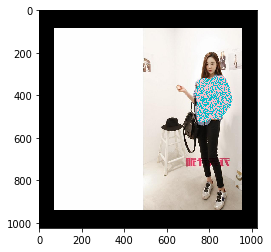

In [76]:
change_color=image.copy()
rgb=np.array([r,g,b])
def make_noise(rgb,masking_values):
    '''rgb : array of rgb(float),maskiv_values:(N pixels,3)'''
    change_shape=masking_values.shape
    rgb_std=np.sqrt(abs(np.std(masking_values,axis=0)))
    noise=np.random.normal(rgb,rgb_std,size=change_shape)
    noise[noise<=0]=0
    return noise

noise=make_noise(rgb,image[mask])
change_color[mask]=noise
plt.imshow(change_color)

### Shifting

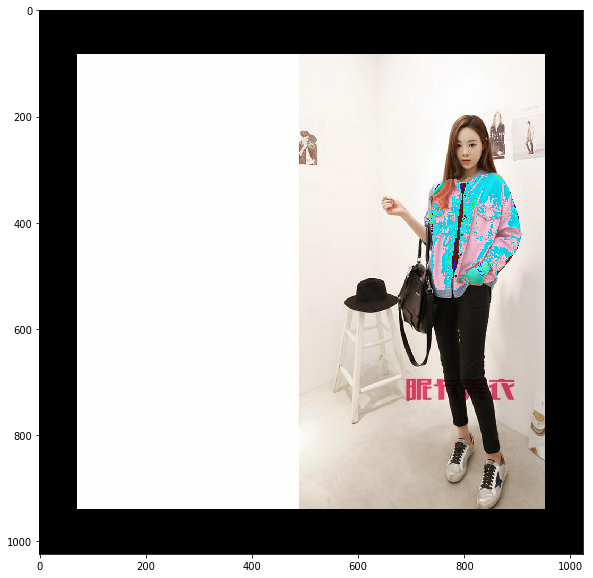

In [77]:
change_color=image.copy()
def shift_mu(rgb,masking_values):
    
    original_rgb_mean=np.mean(masking_values,axis=0)
   
    shift=rgb-original_rgb_mean
    
    shifted=masking_values+shift
    shifted[shifted<=0]=0
    
    return shifted
    
mask_shifted=shift_mu(rgb,image[mask])
change_color[mask]=mask_shifted
plt.figure(figsize=(10,10))
plt.imshow(change_color)

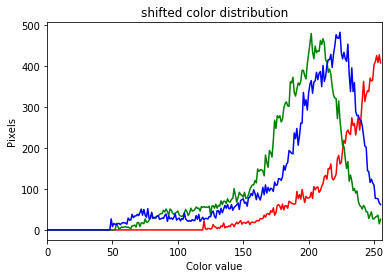

In [78]:
colors = ("r", "g", "b")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])
for idx,color in enumerate(zip(channel_ids, colors)):
    histogram, bin_edges = np.histogram(
        mask_shifted[:,idx], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=color[1])

plt.title('shifted color distribution')
plt.xlabel("Color value")
plt.ylabel("Pixels")

plt.show()

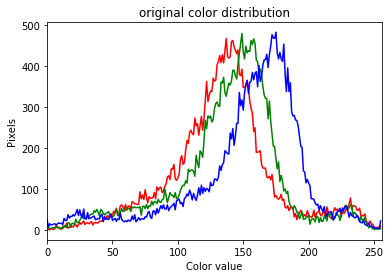

In [79]:
colors = ("r", "g", "b")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])
for idx,color in enumerate(zip(channel_ids, colors)):
    histogram, bin_edges = np.histogram(
        image[mask][:,idx], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=color[1])

plt.title("original color distribution")
plt.xlabel("Color value")
plt.ylabel("Pixels")

plt.show()

## Dominant Color of Segmentation

In [91]:
import cv2
from sklearn.cluster import KMeans

class DominantColors:

    CLUSTERS = None
    IMAGE = None
    COLORS = None
    LABELS = None
    
    def __init__(self,image,clusters,roi=None,):
        '''roi:np.array([x1,y1,x2,y2])'''
        self.CLUSTERS = clusters
        self.IMAGE = image
        self.roi=roi
        
    def dominantColors(self):
    
        #read image
        
        #img=self.IMAGE[self.roi[0]:self.roi[2],self.roi[1]:self.roi[3],:]
        
        #img = img.reshape((img.shape[0] * img.shape[1], 3))
        
        #save image after operations
        #self.IMAGE = img
        
  
        
        #using k-means to cluster pixels
        kmeans = KMeans(n_clusters = self.CLUSTERS)
        kmeans.fit(self.IMAGE)
        
        #the cluster centers are our dominant colors.
        self.COLORS = kmeans.cluster_centers_
        
        #save labels
        self.LABELS = kmeans.labels_
        
        #returning after converting to integer from float
        return self.COLORS.astype(int)
    
    def rgb_to_hex(self, rgb):
        return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))
    
    def plotClusters(self):
        #plotting 
        fig = plt.figure()
        ax = Axes3D(fig)        
        for label, pix in zip(self.LABELS, self.IMAGE):
            ax.scatter(pix[0], pix[1], pix[2], color = self.rgb_to_hex(self.COLORS[label]))
        plt.show()
        
        
    def plotHistogram(self):
       
        #labels form 0 to no. of clusters
        numLabels = np.arange(0, self.CLUSTERS+1)
       
        #create frequency count tables    
        (hist, _) = np.histogram(self.LABELS, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        
        #appending frequencies to cluster centers
        colors = self.COLORS
        
        #descending order sorting as per frequency count
        colors = colors[(-hist).argsort()]
        hist = hist[(-hist).argsort()] 
        
        #creating empty chart
        chart = np.zeros((50, 500, 3), np.uint8)
        start = 0
        
        #creating color rectangles
        for i in range(self.CLUSTERS):
            end = start + hist[i] * 500
            
            #getting rgb values
            r = colors[i][0]
            g = colors[i][1]
            b = colors[i][2]
            
            #using cv2.rectangle to plot colors
            cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
            start = end	
        
        #display chart
        plt.figure()
        plt.axis("off")
        plt.imshow(chart)
        plt.show()

  
        
clusters = 10

roi_idx=results[0]['rois'][prediction_id]
cropped_img=image[roi_idx[0]:roi_idx[2],roi_idx[1]:roi_idx[3],:]

masked_image=image[mask]
dc = DominantColors(masked_image,clusters) 

colors = dc.dominantColors()

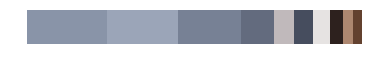

In [92]:
dc.plotHistogram()

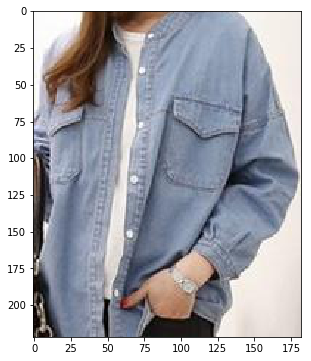

In [88]:
plt.figure(figsize=(6,6))
plt.imshow(cropped_img)

In [226]:
main_color=colors[0]

In [240]:
copy_img=cropped_img.copy()

In [288]:
def channel_mask(a,b:int):
    #print(a.shape)
    boolean=np.array((a<b+1)&(a>b-1))
    print(boolean.shape)
    return boolean

In [294]:
mask=np.zeros(copy_img.shape)
for idx,cha in enumerate(main_color):
    masking=channel_mask(copy_img[:,:,idx],cha)
    mask[:,:,idx]=masking

(301, 171)
(301, 171)
(301, 171)


In [299]:
cropped_img[mask.all(axis=2)]

array([], shape=(0, 3), dtype=uint8)

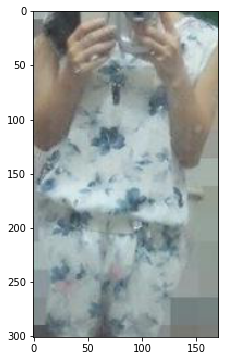

In [234]:
plt.figure(figsize=(6,6))
plt.imshow(copy_img)

In [189]:
cropped_img.shape

(400, 266, 3)

In [198]:
print(main_color)

[119  84 106]


In [247]:
cropped_img[(cropped_img<main_color+1).all(axis=2)&(cropped_img>main_color-1).all(axis=2)]

array([], shape=(0, 3), dtype=uint8)

In [254]:
((cropped_img<main_color+3).all(axis=2)&(cropped_img>main_color-3).all(axis=2))

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])